# Python classes
---
Alexandre Boucaud <aboucaud@ias.u-psud.fr>

## Overview

* [Class definition](#Class-definition)
* [Inheritance](#Inheritance)
* [Class method](#Class-method)
* [Static method](#Static-method)
* [`__repr__` and `__str__`](#String-representation)
* [`property`](#Property)
* [Name mangling](#Name-mangling)
* [Summary](#Summary:-New-style-Python-Classes) and [references](#Some-references)

## Prerequisites for the course

To make code compatible with both Python 2 and Python 3

In [1]:
from __future__ import print_function, division

# Class definition

**Inherit from `object`** or other classes

In [2]:
class Array(object):
    """Array toolkit"""

Has both **class** and **instance** variables.

In [3]:
class Array(object):
    """Array toolkit"""
    
    version = '0.1b'                      # class variable
    
    def __init__(self, shape):
        self.size_y, self.size_x = shape  # instance variables

`__init__` isn't a constructor. It's job is to initialize the instance variables. 

`__init__` takes an existing instance `self` and populates it with instance variables.

**Define** its own functions

In [4]:
class Array(object):
    """Array toolkit"""
    
    version = '0.1' 
    
    def __init__(self, shape):
        self.size_y, self.size_x = shape 
        
    def area(self):
        """Pixel area of the array"""
        return self.size_x * self.size_y

Regular methods have `self` as first argument. 

`self` is a Python convention but any argument name can be used (e.g. `this`).

## Test of the class

In [5]:
print("Array version", Array.version)

Array version 0.1


In [6]:
A = Array((25, 25))
print("An array of shape ({0}x{1}) "
      "has an area of {2} sq.pixels".format(A.size_y, A.size_x, A.area()))

An array of shape (25x25) has an area of 625 sq.pixels


# Inheritance

Let's add a new method to the `Array` class.

In [7]:
class Array(object):
    """Array toolkit"""
    
    version = '0.2'
    
    def __init__(self, shape):
        self.size_y, self.size_x = shape
        
    def area(self):
        """Pixel area of the array"""
        return self.size_x * self.size_y
    
    def perimeter(self):
        """Circumference of the array"""
        return 2 * (self.size_x + self.size_y)

Say we'd like to know the perimeter of the array with a 1 pixel white frame around.

One could try:

In [8]:
A = Array((25, 25))

array_perimeter = A.perimeter()
frame_perimeter = array_perimeter + 8

print("Frame perimeter : {} pixels".format(frame_perimeter))

Frame perimeter : 108 pixels


Or one could just inherit from `Array` to create a sub class `Frame` and redefine the method.

In [9]:
class Frame(Array):
    """Frame object inherited from Array"""
    
    def perimeter(self):
        """Circumference of the frame"""
        return Array.perimeter(self) + 8

Change functionality through **subclassing**.

If the parent gets called in the subclass method then it is called **extending**.

If the parent does not get called in the subclass method then it is called **overriding**.

## Test of the inherited class

In [10]:
print("Array version", Array.version)

Array version 0.2


In [11]:
A = Array((70, 50))
print("The array of shape ({0}x{1}) "
      "has a perimeter of {2} pixels".format(A.size_y, A.size_x, A.perimeter()))

The array of shape (70x50) has a perimeter of 240 pixels


In [12]:
F = Frame((70, 50))
print("while the frame of shape ({0}x{1}) "
      "has a perimeter of {2} pixels".format(F.size_y, F.size_x, F.perimeter()))

while the frame of shape (70x50) has a perimeter of 248 pixels


# Class method

Depending on their needs, different users may want different constructor signatures.

When the API is fixed, a **converter** function is thus always needed.

---

_Example:_ create an Array method from a FITS image

In [13]:
import astropy.io.fits as pyfits

def fits2shape(filename):
    img = pyfits.getdata(filename)
    return img.shape

fitsfile = 'data/array.fits'
A = Array(fits2shape(fitsfile))

For such alternate constructors, the `classmethod` is particularly efficient

In [14]:
class Array(object):
    """Array toolkit"""
    
    version = '0.3b'
    
    def __init__(self, shape):
        self.size_y, self.size_x = shape
    
    @classmethod                   # classmethod decorator
    def from_fits(cls, filename):  # cls is the first argument in a classmethod
        """Construct an Array from a FITS image"""
        array = pyfits.getdata(filename)
        return Array(array.shape)           
    
    def area(self):
        """Pixel area of the array"""
        return self.size_x * self.size_y
    
    def perimeter(self):
        """Circumference of the array"""
        return 2 * (self.size_x + self.size_y)

## Test of the classmethod constructor

In [15]:
print("Array version", Array.version)

Array version 0.3b


In [16]:
A = Array.from_fits(fitsfile)

print("The FITS image '{2}' is an array of shape ({0}x{1}).".format(A.size_y, A.size_x, fitsfile))
print("It has a perimeter of {0} pixels "
      "and an area of {1} sq.pix".format(A.perimeter(), A.area()))

The FITS image 'array.fits' is an array of shape (16x12).
It has a perimeter of 56 pixels and an area of 192 sq.pix


This should also work with subclasses

In [17]:
class Frame(Array):
    """Frame object inherited from Array"""
    
    def perimeter(self):
        """Circumference of the frame"""
        return Array.perimeter(self) + 8

In [18]:
print("Frame version", Frame.version)

F = Frame.from_fits(fitsfile)
print("The FITS image '{2}' is an array of shape ({0}x{1}).".format(F.size_y, F.size_x, fitsfile))
print("Its frame has a perimeter of {0} pixels "
      "and an area of {1} sq.pix".format(F.perimeter(), F.area()))

Frame version 0.3b
The FITS image 'array.fits' is an array of shape (16x12).
Its frame has a perimeter of 56 pixels and an area of 192 sq.pix


***Something went wrong !***

Indeed, when finalizing the alternate constructor, we returned an `Array`.

In order to **achieve inheritance**, one must use the `cls` argument as return value.

In [19]:
class Array(object):
    """Array toolkit"""
    
    version = '0.3'
    
    def __init__(self, shape):
        self.size_y, self.size_x = shape
    
    @classmethod                  
    def from_fits(cls, filename):  
        """Construct an Array from a FITS image"""
        array = pyfits.getdata(filename)
        return cls(array.shape)  # cls is returned to preserve inheritance       
    
    def area(self):
        """Pixel area of the array"""
        return self.size_x * self.size_y
    
    def perimeter(self):
        """Circumference of the array"""
        return 2 * (self.size_x + self.size_y)

## Let's try this again

In [20]:
class Frame(Array):
    """Frame object inherited from Array"""
    
    def perimeter(self):
        """Circumference of the frame"""
        return Array.perimeter(self) + 8

In [21]:
print("Frame version", Frame.version)

F = Frame.from_fits(fitsfile)
print("The FITS image '{2}' is an array of shape ({0}x{1}).".format(F.size_y, F.size_x, fitsfile))
print("Its frame has a perimeter of {0} pixels "
      "and an area of {1} sq.pix".format(F.perimeter(), F.area()))

Frame version 0.3
The FITS image 'array.fits' is an array of shape (16x12).
Its frame has a perimeter of 64 pixels and an area of 192 sq.pix


This time it worked !

# Static method

A new function needs to be implemented for conversion purposes.

In [22]:
def pix_to_arcsec(pixels):
    """Convert pixels to sky angle in arcseconds"""
    return round(pixels * 0.15, 3)

This function is 
* related to the `Array` class,
* obviously related to `Array` subclasses,

BUT

* does neither use class nor instance variable

One could simply add it as a common class function...

In [23]:
class Array(object):
    """Array toolkit"""
    
    version = '0.4b'
    
    def __init__(self, shape):
        self.size_y, self.size_x = shape
        
    @classmethod           
    def from_fits(cls, filename):
        """Construct an Array from a FITS image"""
        array = pyfits.getdata(filename)
        return cls(array.shape)        
        
    def area(self):
        """Pixel area of the array"""
        return self.size_x * self.size_y
    
    def perimeter(self):
        """Circumference of the array"""
        return 2 * (self.size_x + self.size_y)

    @staticmethod
    def pix_to_arcsec(self, pixels):
        """Convert pixels to sky angle in arcseconds"""
        return round(pixels * 0.15, 3)

but since it **does not rely on `self`**, it is clearer to use a static method instead.

In [24]:
class Array(object):
    """Array toolkit"""
    
    version = '0.4'
    
    def __init__(self, shape):
        self.size_y, self.size_x = shape
        
    @classmethod           
    def from_fits(cls, filename):
        """Construct an Array from a FITS image"""
        array = pyfits.getdata(filename)
        return cls(array.shape)        
        
    def area(self):
        """Pixel area of the array"""
        return self.size_x * self.size_y
    
    def perimeter(self):
        """Circumference of the array"""
        return 2 * (self.size_x + self.size_y)

    @staticmethod
    def pix_to_arcsec(pixels):
        """Convert pixels to sky angle in arcseconds"""
        return round(pixels * 0.15, 3)

The purpose of static method is to **attach functions to classes**.

It **improves the findability** of the function and makes sure that people use the function **in the appropriate context**.

## Test of the static method

In [25]:
print("Array version", Array.version)

Array version 0.4


In [26]:
A = Array.from_fits(fitsfile)
sizey, sizex = A.size_y, A.size_x

print("The FITS image '{2}' is an array of shape ({0}x{1}),".format(A.size_y, A.size_x, fitsfile))
print("which corresponds to an angle on the sky of {0} x {1} sq.arcseconds".format(A.pix_to_arcsec(sizex), A.pix_to_arcsec(sizey)))

The FITS image 'array.fits' is an array of shape (16x12),
which corresponds to an angle on the sky of 1.8 x 2.4 sq.arcseconds


# String representation

Every instance of a Python **object** is associated with a **string representation**.

It carries information on the object or particular instance.

In [27]:
class Test(object):
    """Test class"""
    version = '0.1'
    
    def __repr__(self):
        return "String representation of Test class"

That string representation is defined by the `__repr__` method and triggered with 

* the build-in method `repr()`
* the built-in method `str()` 


and printed by 

* the raw terminal output
* the `print()` method.

In [28]:
print(Test())

String representation of Test class


In [29]:
print(repr(Test()))

String representation of Test class


There is also an optional **alternate** string representation defined by the `__str__` method, which is exclusively triggered by `str()` and `print()`.

In [30]:
class Test(object):
    """Test class"""
    version = '0.2'
    
    def __repr__(self):
        return "String representation of Test class"
    
    def __str__(self):
        return "Alternate string representation of Test class"

In [31]:
print(Test())

Alternate string representation of Test class


In [32]:
print(repr(Test()))

String representation of Test class


If `__repr__` is defined but `__str__` is not, **`__str__` defaults to `__repr__`**.

It is useful to declare the string representation when you define a new class.

In [33]:
class Array(object):
    """Array toolkit"""
    
    version = '0.5'
    
    def __init__(self, shape):
        self.size_y, self.size_x = shape
        
    def __repr__(self):
        """String representation of the class"""
        return "{0} of shape ({1}x{2})".format(self.__class__.__name__, self.size_y, self.size_x)
        
    @classmethod           
    def from_fits(cls, filename):
        """Construct an Array from a FITS image"""
        array = pyfits.getdata(filename)
        return cls(array.shape)        
        
    def area(self):
        """Pixel area of the array"""
        return self.size_x * self.size_y
    
    def perimeter(self):
        """Circumference of the array"""
        return 2 * (self.size_x + self.size_y)

    @staticmethod
    def pix_to_arcsec(pixels):
        """Convert pixels to sky angle in arcseconds"""
        return round(pixels * 0.15, 3)

## Test of the Array string repr

In [34]:
print("Array version", Array.version)

Array version 0.5


In [35]:
A = Array((12, 21))

In [36]:
print(A)

Array of shape (12x21)


In [37]:
print(repr(A))

Array of shape (12x21)


## What about subclasses ?

In [38]:
class Frame(Array):
    """Frame object inherited from Array"""
    
    def perimeter(self):
        """Circumference of the frame"""
        return Array.perimeter(self) + 8

In [39]:
print("Frame version", Frame.version)

F = Frame((12, 21))

print(F)
print(repr(F))

Frame version 0.5
Frame of shape (12x21)
Frame of shape (12x21)


# Property

What if instead of storing two variables `size_x` and `size_y` you wanted to 

1) only store a single variable 

**AND**

2) continue using the `size_x` and `size_y` attributes not to break code ?!

The answer is to use a `@property` decorator, that defines getter and setter methods for a given variable.

In our example, this would look like

In [40]:
class Array(object):
    """Array toolkit"""
    
    version = '0.6'
    
    def __init__(self, shape):
        self.shape = list(shape)
    
    @property
    def size_x(self):
        return self.shape[1]
    
    @size_x.setter
    def size_x(self, size):
        self.shape[1] = size
        
    @property
    def size_y(self):
        return self.shape[0]
    
    @size_y.setter
    def size_y(self, size):
        self.shape[0] = size
    
    def area(self):
        """Pixel area of the array"""
        return self.size_x * self.size_y
    
    def perimeter(self):
        """Circumference of the array"""
        return 2 * (self.size_x + self.size_y)

`size_x` and `size_y` and now properties and no more variables. They are pointers to entries of the shape list. Thus they do not use memory.

***NOTE:*** The initialization of `shape` in `__init__` is needed in our case for Python to know shape is a list. But for single variables, such initialization is in general not necessary.

---

An other usage of the `property` is to access variables that require some computation, without using a function call `()`.

In such case, the `@method.setter` is not used.

## Test of the properties

In [41]:
print("Array version", Array.version)

Array version 0.6


In [42]:
A = Array((12, 21))

In [43]:
print("Size X = {0}\nSize Y = {1}\nShape = {2}".format(A.size_x, A.size_y, A.shape))

Size X = 21
Size Y = 12
Shape = [12, 21]


# Name mangling

The **name mangling** is a step used for **protecting class functions** against possible overrides in a subclass.

Such issues might happen if for some reason a given function relies on an other one.

In [44]:
class Array(object):
    """Array toolkit"""
    
    version = '0.7b'
    
    def __init__(self, shape):
        self.size_y, self.size_x = shape
             
    def area(self):
        """Pixel area of the array"""
        p = self.perimeter()
        size_y = int(p / 2) - self.size_x
        return self.size_x * size_y
    
    def perimeter(self):
        """Circumference of the array"""
        return 2 * (self.size_x + self.size_y)

In such case, the inheritance and method overridding will ***break*** the function.

In [45]:
class Frame(Array):
    """Frame object inherited from Array"""
    
    def perimeter(self):
        """Circumference of the frame"""
        return Array.perimeter(self) + 8

In [46]:
print("Array version", Array.version)
print("Frame version", Frame.version)

Array version 0.7b
Frame version 0.7b


In [47]:
A = Array((12, 21))
F = Frame((12, 21))

print("Array area: {0} sq.pix\n"
      "Frame area: {1} sq.pix".format(A.area(), F.area()))

Array area: 252 sq.pix
Frame area: 336 sq.pix


Since there are **no private methods** in Python, a way to solve this is to attach a given method to the class.

This is precisely what mangling does.

In [48]:
class Array(object):
    """Array toolkit"""
    
    version = '0.7'
    
    def __init__(self, shape):
        self.size_y, self.size_x = shape
             
    def area(self):
        """Pixel area of the array"""
        p = self.__perimeter()
        size_y = int(p / 2) - self.size_x
        return self.size_x * size_y
    
    def perimeter(self):
        """Circumference of the array"""
        return 2 * (self.size_x + self.size_y)
    
    __perimeter = perimeter

When interpreting the code, Python **replaces `__method` by `_Class__method`** in the class dictionary.

In [49]:
methods = [method 
           for method in Array.__dict__.keys()
           if not method.endswith('__')]
print("Array method dictionary : {}".format(methods))

Array method dictionary : ['version', '_Array__perimeter', 'perimeter', 'area']


This way, even if the subclass uses the same trick, it will create a `_Subclass__method` and will thus not override the parent method.

In [50]:
class Frame(Array):
    """Frame object inherited from Array"""
    
    def perimeter(self):
        """Circumference of the frame"""
        return Array.perimeter(self) + 8

In [51]:
print("Array version", Array.version)
print("Frame version", Frame.version)

Array version 0.7
Frame version 0.7


In [52]:
A = Array((12, 21))
F = Frame((12, 21))

print("Array area: {0} sq.pix\n"
      "Frame area: {1} sq.pix".format(A.area(), F.area()))

Array area: 252 sq.pix
Frame area: 252 sq.pix


## Summary: New style Python Classes

1. Inherit from object
2. Instance variables for information unique to an instance. Class variables for data shared among all instances.
3. Regular methods need `self` to operate on instance data
4. Class methods implement alternative constructors. They need `cls` so they can create subclass instances as well.
5. Static methods attach functions that do not need `self` or `cls` to classes. Static methods improve discoverability and require context to be specified.
6. String representation is defined in the `__repr__` method and optionally in the `__str__` method.
7. A `property()` lets getter and setter methods be invoked automatically by attribute access. This allows Python classes to freely expose their instance variables.
8. Name mangling (or double underscore) makes `self` refer to this class and not its children. It allows the subclass to override any method without breaking the others.

## Some references


* [Python cheatsheet](https://www.ias.u-psud.fr/pperso/aboucaud/cheatsheet.html)

---

* [Official Python documentation on classes](https://docs.python.org/3/tutorial/classes.html)
* [Object Oriented programming in Python](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/)

* [Première approche des classes (FR)](https://openclassrooms.com/courses/apprenez-a-programmer-en-python/premiere-approche-des-classes)
* [Classes et métaclasses (FR)](https://zestedesavoir.com/tutoriels/954/notions-de-python-avancees/)

---

* [Going further with Python](http://sebastianraschka.com/Articles/2014_deep_python.html)


The main reference for this course is a talk from **Raymond Hettinger**.

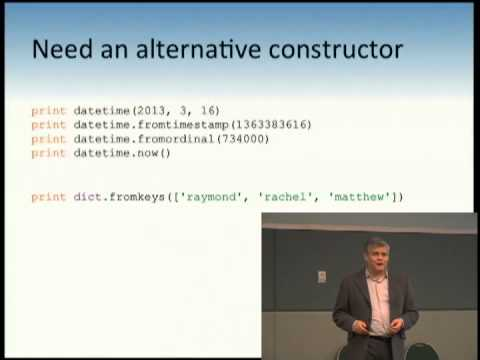

In [53]:
from IPython.display import YouTubeVideo
YouTubeVideo('HTLu2DFOdTg')

I can only encourage you to check his very clear and instructive talks.